# Libraries

All imports

In [1]:
import numpy as np

import autoencoder
import visualization

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load and prepare data
Importing and preprocessing of images into a image dataset

In [2]:
image_size = (152, 152)

normal_dir = "../dataset/AUTO_Input/train/"
anomaly_dir = "../dataset/AUTO_Input/test/"

normal_images = autoencoder.create_image_dataset(normal_dir, image_size)
anomaly_images = autoencoder.create_image_dataset(anomaly_dir, image_size)

Found 209 files.
Found 65 files.


# Build and compile autoencoder

In [3]:
ae = autoencoder.build_and_compile(image_size)
ae.summary()

(38, 38, 32)
46208


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 152, 152, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 152, 152, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 152, 152, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 76, 76, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 76, 76, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 76, 76, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    47,318,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 46208)          │    47,363,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 76, 76, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 152, 152, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 152, 152, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,720,227 (361.33 MB)

 Trainable params: 94,720,099 (361.33 MB)

 Non-trainable params: 128 (512.00 B)

# Create train test split

In [4]:
train, test = train_test_split(normal_images, test_size=0.2)

# Train the model

In [5]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_delta=0.0005)
early_stop = EarlyStopping(monitor="val_loss", patience=5, min_delta=0.0002, restore_best_weights=True)
callbacks = [reduce_lr, early_stop]

history = autoencoder.fit_model(ae, train, epochs=5, batch_size=64, callbacks=callbacks)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 0.0833 - val_loss: 0.0592 - learning_rate: 5.0000e-04
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.0411 - val_loss: 0.0519 - learning_rate: 5.0000e-04
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0383 - val_loss: 0.0449 - learning_rate: 5.0000e-04
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0336 - val_loss: 0.0357 - learning_rate: 5.0000e-04
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0258 - val_loss: 0.0251 - learning_rate: 5.0000e-04


# Plot training loss and validation loss from history

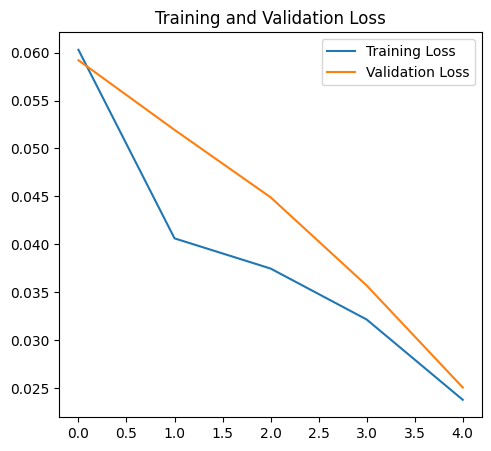

In [6]:
visualization.plot_metrics(history, accuracy=False)

# Predict on normal test data and anomalous data

In [7]:
normal_predictions = ae.predict(test)
anomaly_predictions = ae.predict(anomaly_images)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step


# Visual comparison of original images and predicted image

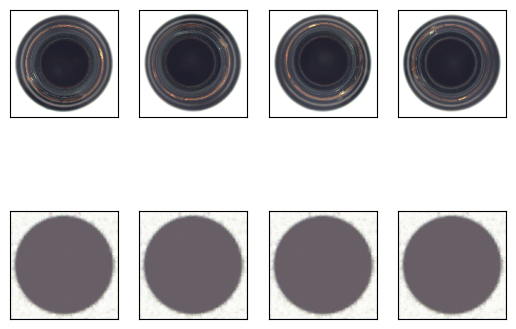

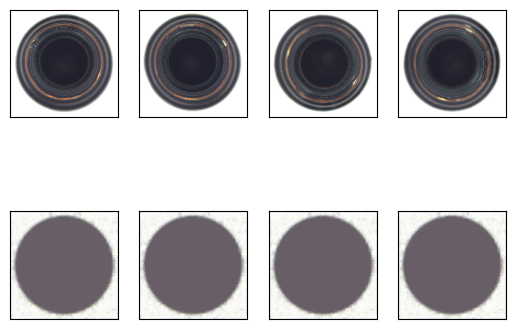

In [8]:
visualization.display_before_after(test, normal_predictions)
visualization.display_before_after(test, anomaly_predictions)

# Calculate similarity score and get image of difference

In [12]:
win_size = 9
gaussian_weights = True

normal_scores, normal_diffs = autoencoder.get_scores_and_diffs(
    test, 
    normal_predictions, 
    win_size=win_size, 
    gaussian_weights=gaussian_weights,
)

anomaly_scores, anomaly_diffs = autoencoder.get_scores_and_diffs(
    anomaly_images,
    anomaly_predictions,
    win_size=win_size,
    gaussian_weights=gaussian_weights,
)

# Plot images with diff image

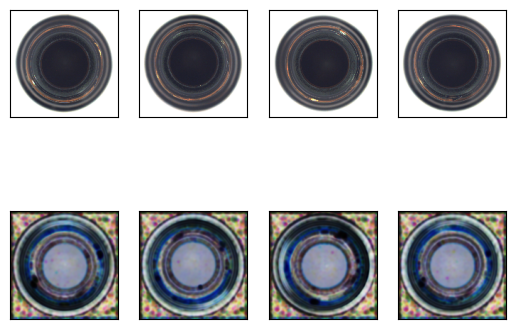

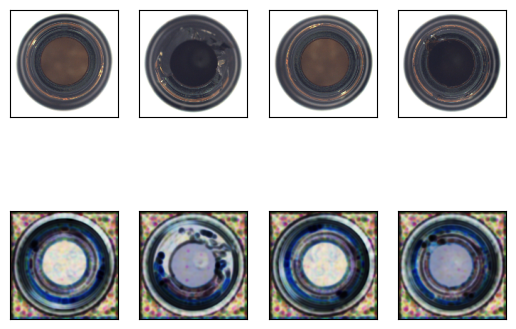

In [13]:
visualization.display_before_after(test, normal_diffs)
visualization.display_before_after(anomaly_images, anomaly_diffs)

# Calculate threshold between normal and anomalous data

In [14]:
min_normal = min(normal_scores)
max_anomaly = max(anomaly_scores)
threshold = (min_normal + max_anomaly) / 2

print(min_normal)
print(max_anomaly)
print(threshold)

0.38527742
0.48314857
0.43421298


# Make anomaly predictions

In [ ]:
y_pred = autoencoder.predict_anomalies(test)